In [1]:
import matplotlib as mpl
mpl.rcParams['font.sans-serif']=['FangSong']
import matplotlib.pyplot as plt
import numpy as np
from skimage import data
from pipe_fn import infix, and_then
from linq.standard.general import Map

In [2]:
"""
加载图片
"""
img = data.rocket()

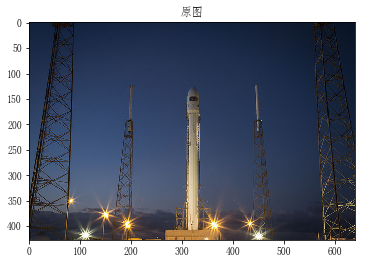

In [3]:
plt.imshow(img)
plt.title('原图')
plt.show()

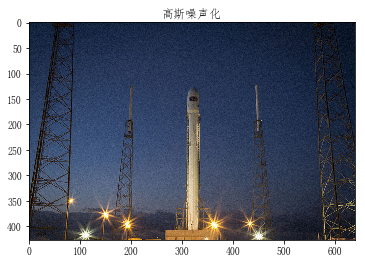

In [4]:
"""
normal: 均值为0, 标准差为6的高斯分布序列
"""
normal = np.random.normal(0, 6.0, size=(img.shape[:2]))

"""
gaussian_noise: 用以上高斯分布序列进行噪声化的函数
"""
gaussian_noise = and_then(
    lambda x: x.astype(float),  # 转化为浮点数组
    infix/np.transpose@(2, 0, 1), # 将图片的(m x n x 3)转为(3 x m x n)
    infix/Map@(lambda x: x + normal), # 每个色道都高斯噪声化
    infix/np.stack@2, # 将三个转化后的色道在第3个维度组合起来，形成(m x n x 3)规模的张量。
    lambda x: x.clip(0, 255).astype(np.uint8))

gaussian_noisy_img = gaussian_noise(img)

plt.title('高斯噪声化')
plt.imshow(gaussian_noisy_img)
plt.show()

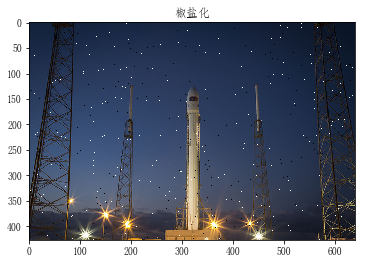

In [5]:
"""
椒盐噪声产生器
"""
salt = 0
peper = 1
other = 2

def salt_and_pepper(img, prob = 0.01, salt_prob=0.5):
    """
    适用于单色道图或者灰度图。根据prob概率返回一个椒盐化图。椒化和盐化概率为salt_prob。
    """
    
    rnds = np.random.random(img.shape[:2])
    
    salt_types = np.random.random(img.shape[:2]) # 是255还是0
    
    salt_peper_indices = np.vectorize(
                lambda rnd, salt_type: ((
                        salt if salt_type>0.5 else 
                        peper) if prob > rnd else other), 
                        signature='(),()->()')(
                                    rnds, salt_types).reshape(img.shape[:2])
    
    img = img.copy()
    
    if img.ndim is 3:
        if img.shape[2] is 3:
            img[salt_peper_indices == salt] = np.array([255, 255, 255])
            img[salt_peper_indices == peper] = np.array([0, 0, 0])
        else:
            img[salt_peper_indices == salt] = np.array([255])
            img[salt_peper_indices == peper] = np.array([0])
    else:
        img[salt_peper_indices == salt] = 255
        img[salt_peper_indices == peper] = 0
    
    return img

salt_and_pepper_noisy_mg = salt_and_pepper(img, prob=0.005)
plt.imshow(salt_and_pepper_noisy_mg)
plt.title('椒盐化')
plt.show()
    

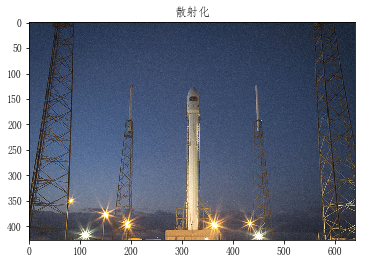

In [6]:
"""
poisson_noise_dist: 泊松噪声, lambda值为20
"""
poisson_noise_dist = np.random.poisson(20, img.shape[:2]).astype(float)

poisson_noise = and_then(
    lambda x: x.astype(float),  # 转化为浮点数组
    infix/np.transpose@(2, 0, 1), # 将图片的(m x n x 3)转为(3 x m x n)
    infix/Map@(lambda x: x + poisson_noise_dist), # 每个色道都泊松噪声化
    infix/np.stack@2, # 将三个转化后的色道在第3个维度组合起来，形成(m x n x 3)规模的张量。
    lambda x: x.clip(0, 255).astype(np.uint8))

poisson_noisy_img = poisson_noise(img)
plt.imshow(poisson_noisy_img)
plt.title('散射化')
plt.show()

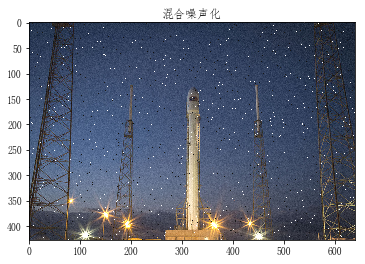

In [7]:
"""
先高斯，再椒盐，在泊松
"""
mixed_noise = and_then(gaussian_noise, 
                       salt_and_pepper,
                       poisson_noise)

mixed_noisy_img = mixed_noise(img)

plt.imshow(mixed_noisy_img)
plt.title('混合噪声化')
plt.show()


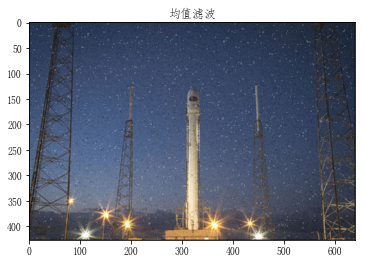

In [8]:
from scipy.signal import correlate2d
"""
3 x 3 均方滤波
"""

average_filter_operator = np.ones((3, 3))/9  # 均方滤波算子

average_filter = and_then(
    infix/np.transpose@(2, 0, 1),
    np.vectorize(lambda image: correlate2d(image, average_filter_operator, mode='same'), signature='(m,n)->(m,n)'),
    infix/np.stack@2, # 将三个转化后的色道在第3个维度组合起来，形成(m x n x 3)规模的张量。
    lambda x: x.astype(np.uint8))
    
average_filtered_img = average_filter(mixed_noisy_img)
plt.title('均值滤波')
plt.imshow(average_filtered_img)
plt.show()

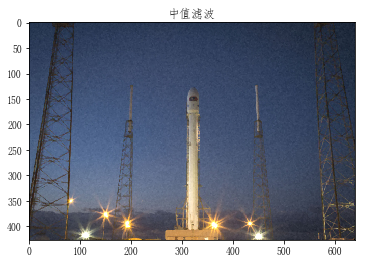

In [9]:
from scipy.signal import medfilt2d
"""
3 x 3 中值滤波
"""

median_filter = and_then(
    infix/np.transpose@(2, 0, 1),
    np.vectorize(lambda image: medfilt2d(image, kernel_size=3), signature='(m,n)->(m,n)'),
    infix/np.stack@2, # 将三个转化后的色道在第3个维度组合起来，形成(m x n x 3)规模的张量。
    lambda x: x.astype(np.uint8))
    
median_filtered_img = median_filter(mixed_noisy_img)
plt.title('中值滤波')
plt.imshow(median_filtered_img)
plt.show()


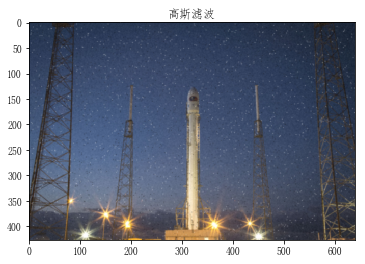

In [10]:
from scipy.ndimage import gaussian_filter as _gaussian_filter
"""
sigma = 1.0 高斯滤波

"""

gaussian_filter = and_then(
    infix/np.transpose@(2, 0, 1),
    np.vectorize(lambda image: _gaussian_filter(image, sigma=1), signature='(m,n)->(m,n)'),
    infix/np.stack@2, # 将三个转化后的色道在第3个维度组合起来，形成(m x n x 3)规模的张量。
    lambda x: x.astype(np.uint8))

gaussian_filtered_img = gaussian_filter(mixed_noisy_img)
plt.title('高斯滤波')
plt.imshow(gaussian_filtered_img)
plt.show()
